In [22]:
# 차분 한거
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# ============================================================
# 0. 데이터 로딩 & 공통 전처리 (ret_prev = 로그수익률)
# ============================================================
path = "../../preprocessing/log공선성제거_Final_data.csv"
df = pd.read_csv(path)

# Date가 있으면 시계열 정렬
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)

# 로그 수익률 생성: ret_prev = logP_t - logP_{t-1}
# (y_target_log = log(P_t) 라고 가정)
df["ret_prev"] = df["y_target_log"] - df["y_target_log"].shift(1)

target_col = "ret_prev"
drop_cols = ["Date", target_col,'y_target_log']  # 필요하면 y_target_log 도 피처에서 제외

feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
y = df[target_col]

# 숫자형 피처만 사용
X = X.select_dtypes(include=[np.number])

# NaN 제거 (ret_prev 첫 행, 기타 결측 등)
df_combined = pd.concat([X, y], axis=1).dropna()

X = df_combined.drop(columns=[target_col])
y = df_combined[target_col]

print("최종 사용 행 개수:", len(X))
print("사용 피처 수:", X.shape[1])

최종 사용 행 개수: 753
사용 피처 수: 5


Train Val Test 분리 + RMSE, R2, feature_importances 구하기

In [23]:
n = len(X)

# 비율 설정
test_ratio = 0.2
valid_ratio = 0.2

test_size  = int(n * test_ratio)
remaining  = n - test_size
valid_size = int(remaining * valid_ratio)
train_size = remaining - valid_size

print(f"총 데이터: {n}")
print(f"train_size: {train_size}")
print(f"valid_size: {valid_size}")
print(f"test_size : {test_size}")

# -----------------------------
# 1) train / valid / test 분할
# -----------------------------
X_train = X.iloc[:train_size].copy()
y_train = y.iloc[:train_size].copy()

X_valid = X.iloc[train_size : train_size + valid_size].copy()
y_valid = y.iloc[train_size : train_size + valid_size].copy()

X_test  = X.iloc[train_size + valid_size :].copy()
y_test  = y.iloc[train_size + valid_size :].copy()   # y_test 정의

print(len(X_train), len(X_valid), len(X_test))

# train_all = train + valid
X_train_all = pd.concat([X_train, X_valid], axis=0)
y_train_all = pd.concat([y_train, y_valid], axis=0)

# -----------------------------
# 2) XGBoost 학습 / 예측 / 평가
# -----------------------------
test_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    min_child_weight=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="rmse",
)

test_model.fit(
    X_train_all,
    y_train_all,
    eval_set=[(X_train_all, y_train_all)],
    verbose=False
)

# 예측값 저장
y_test_pred_xgb = test_model.predict(X_test)

# y_test 사용해서 평가
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
r2   = r2_score(y_test, y_test_pred_xgb)

print("RMSE:", rmse)
print("R2:", r2)
print(np.unique(test_model.feature_importances_))

총 데이터: 753
train_size: 483
valid_size: 120
test_size : 150
483 120 150
RMSE: 0.01710794008575238
R2: -1.007011177863927
[0.15808602 0.16720594 0.17385723 0.22434597 0.27650484]


feature_importances 시각화

In [24]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_name = 'Malgun Gothic' 

# 폰트 설정
plt.rc('font', family=font_name)

# 마이너스 기호가 깨지는 거 방지
plt.rcParams['axes.unicode_minus'] = False

print("VS Code Matplotlib 한글 설정 완료 (NanumGothic)")

VS Code Matplotlib 한글 설정 완료 (NanumGothic)


C:\Users\ssginc07\AppData\Local\Temp\ipykernel_12140\633439154.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


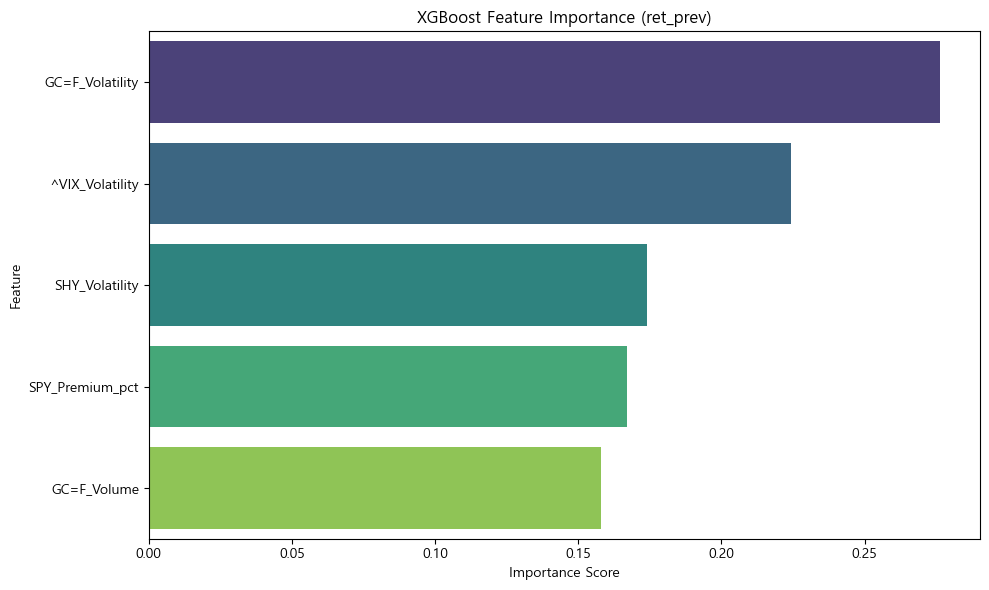

In [25]:
import seaborn as sns

# 1. 피처 중요도 추출
feature_importance = test_model.feature_importances_
feature_names = X_train_all.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# 중요도 0만 있는 경우 대비 → 0 이상 값만 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# 2. 시각화
plt.figure(figsize=(10, max(6, len(importance_df)*0.3)))   # 피처 개수에 따라 높이 자동 조절

sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df,
    palette='viridis'
)

plt.title('XGBoost Feature Importance (ret_prev)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()


Test 예측 vs 실제값 시각화 (차분 안품)

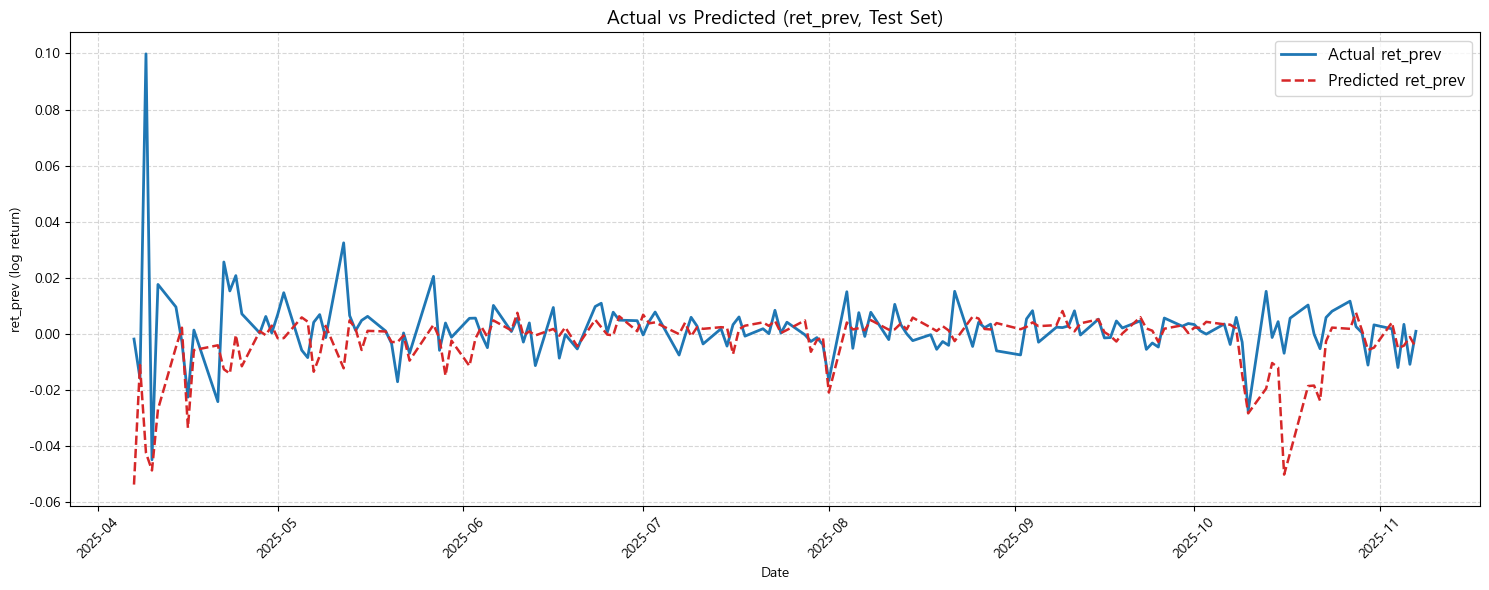

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------------------
# 1. 테스트 날짜 재구성
# -------------------------------------------

# df_combined의 인덱스에 해당하는 날짜 추출
date_all = df.loc[df_combined.index, "Date"].reset_index(drop=True)

# test 구간 시작 인덱스
test_start_idx = train_size + valid_size

# test 구간 날짜 (길이 = y_test)
test_dates = date_all.iloc[test_start_idx : test_start_idx + len(y_test)].reset_index(drop=True)

# -------------------------------------------
# 2. 시각화를 위한 DataFrame 생성
# -------------------------------------------
comparison_df = pd.DataFrame(
    {
        "Actual": y_test.to_numpy(),      # 인덱스 버리고 값만 사용
        "Prediction": y_test_pred_xgb     # np.array
    },
    index=test_dates                     # 날짜 인덱스
)

comparison_df.index.name = "Date"

# -------------------------------------------
# 3. 시계열 비교 플롯
# -------------------------------------------

plt.figure(figsize=(15, 6))

plt.plot(
    comparison_df.index,
    comparison_df["Actual"],
    label="Actual ret_prev",
    color="#1f77b4",        # 진한 파랑
    linewidth=2
)

plt.plot(
    comparison_df.index,
    comparison_df["Prediction"],
    label="Predicted ret_prev",
    color="#d62728",        # 진한 빨강
    linestyle="--",
    linewidth=1.8
)

plt.title("Actual vs Predicted (ret_prev, Test Set)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("ret_prev (log return)")
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Test 예측 vs 실제값 시각화 (차분 품)


==== 최종 Test 성능 (복원된 Level 기준) ====
RMSE: 0.017108
R^2 : 0.946165


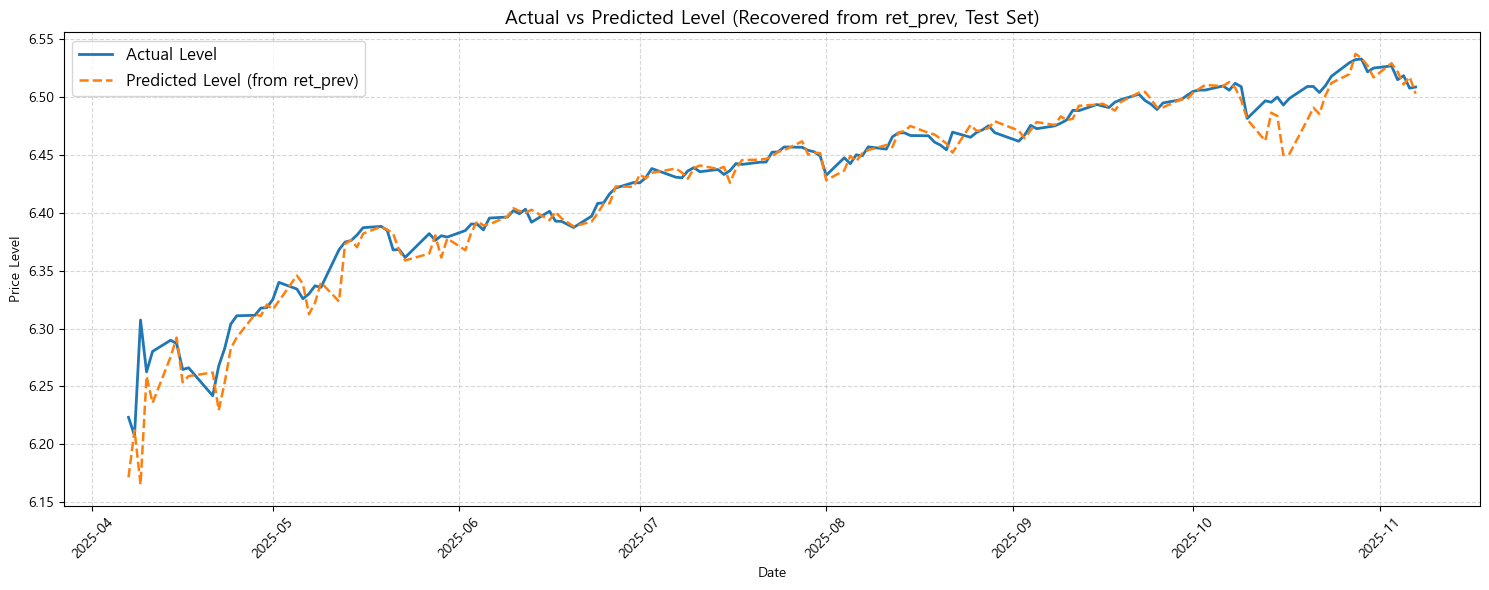

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -------------------------------------------
# 1. 테스트 날짜 재구성
# -------------------------------------------

# df_combined의 인덱스에 해당하는 날짜 추출
date_all = df.loc[df_combined.index, "Date"].reset_index(drop=True)

# test 구간 시작 인덱스
test_start_idx = train_size + valid_size
n_test = len(y_test)

# test 구간 날짜
test_dates = date_all.iloc[test_start_idx : test_start_idx + n_test].reset_index(drop=True)

# ===========================================
# 2. 차분 푼 레벨(가격) 복원
# ===========================================

# ===========================================
# 1. df_combined에 맞춘 y_target_log 전체 (로그 레벨)
# ===========================================
y_log_all = df.loc[df_combined.index, "y_target_log"].reset_index(drop=True)

# ===========================================
# 2. test 구간의 실제 log 레벨
# ===========================================
log_true = y_log_all.iloc[test_start_idx : test_start_idx + n_test].reset_index(drop=True)

# ===========================================
# 3. 직전 실제 log 레벨
# ===========================================
log_prev = y_log_all.iloc[test_start_idx - 1 : test_start_idx - 1 + n_test].reset_index(drop=True)

# ===========================================
# 4. 예측된 차분(ret_prev)을 이용해 log 레벨 복원
#    log(P_t_hat) = log(P_{t-1}^{real}) + pred_ret_prev_t
# ===========================================
log_pred = log_prev + y_test_pred_xgb

# ===========================================
# 5. 로그 레벨 비교용 DataFrame
# ===========================================
comparison_log_df = pd.DataFrame(
    {
        "Actual_Level": log_true.to_numpy(),
        "Pred_Level": log_pred.to_numpy(),
    },
    index=test_dates
)
comparison_log_df.index.name = "Date"

# Level 복원 후 성능 재평가 (복원된 레벨 기준)
rmse_level = np.sqrt(mean_squared_error(comparison_log_df["Actual_Level"], comparison_log_df["Pred_Level"]))
mae_level = mean_absolute_error(comparison_log_df["Actual_Level"], comparison_log_df["Pred_Level"])
r2_level = r2_score(comparison_log_df["Actual_Level"], comparison_log_df["Pred_Level"])

print("\n==== 최종 Test 성능 (복원된 Level 기준) ====")
print(f"RMSE: {rmse_level:.6f}")
print(f"R^2 : {r2_level:.6f}")
print("===========================================")

# ===========================================
# 3. 레벨(가격) 시계열 비교 플롯
# ===========================================

plt.figure(figsize=(15, 6))

plt.plot(
    comparison_log_df.index,
    comparison_log_df["Actual_Level"],
    label="Actual Level",
    linewidth=2
)

plt.plot(
    comparison_log_df.index,
    comparison_log_df["Pred_Level"],
    label="Predicted Level (from ret_prev)",
    linestyle="--",
    linewidth=1.8
)

plt.title("Actual vs Predicted Level (Recovered from ret_prev, Test Set)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price Level")
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

차분 안푼 잔차 그래프

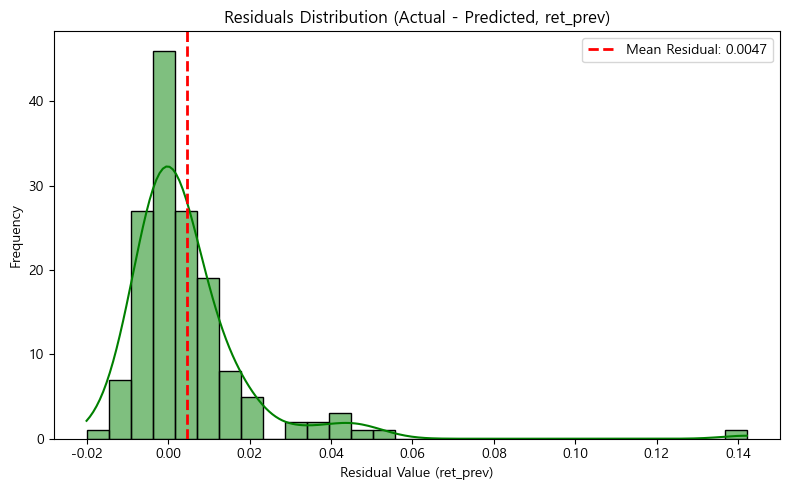

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 잔차 계산 (ret_prev = 로그수익률 기준)
# y_test : 실제값 (Series)
# y_test_pred_xgb : 예측값 (ndarray)
residuals = y_test.values - y_test_pred_xgb

# 2. 잔차 시각화
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='green', edgecolor='black')

plt.title('Residuals Distribution (Actual - Predicted, ret_prev)')
plt.xlabel('Residual Value (ret_prev)')
plt.ylabel('Frequency')

# 잔차 평균 수직선
mean_resid = residuals.mean()
plt.axvline(mean_resid,
            color='red',
            linestyle='dashed',
            linewidth=2,
            label=f'Mean Residual: {mean_resid:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

차분 푼 잔차 그래프

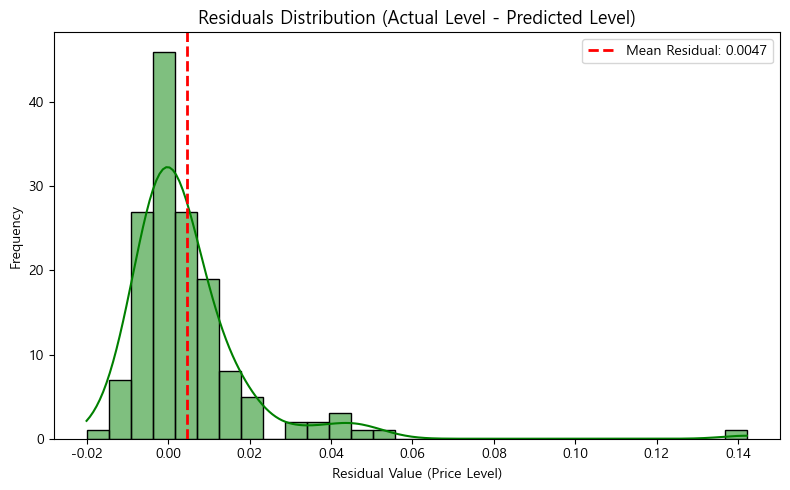

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 레벨 기준 잔차 계산
# comparison_log_df 에서 바로 가져오기
residuals_level = (
    comparison_log_df["Actual_Level"] - comparison_log_df["Pred_Level"]
).values

# 2. 잔차 시각화 (레벨 기준)
plt.figure(figsize=(8, 5))
sns.histplot(residuals_level, bins=30, kde=True, color='green', edgecolor='black')

plt.title('Residuals Distribution (Actual Level - Predicted Level)', fontsize=13)
plt.xlabel('Residual Value (Price Level)')
plt.ylabel('Frequency')

# 잔차 평균 수직선
mean_resid_level = residuals_level.mean()
plt.axvline(
    mean_resid_level,
    color='red',
    linestyle='dashed',
    linewidth=2,
    label=f'Mean Residual: {mean_resid_level:.4f}'
)
plt.legend()
plt.tight_layout()
plt.show()


최적 seq_len 찾고 모델 돌리기

In [30]:
# 차분 한거
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import xgboost as xgb

# ============================================================
# 0. 데이터 로딩 & 공통 전처리 (ret_prev = 로그수익률)
# ============================================================
path = "../../preprocessing/log공선성제거_Final_data.csv"
df = pd.read_csv(path)

# Date가 있으면 시계열 정렬
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)

# 로그 수익률 생성: ret_prev = logP_t - logP_{t-1}
# (y_target_log = log(P_t) 라고 가정)
df["ret_prev"] = df["y_target_log"] - df["y_target_log"].shift(1)

target_col = "ret_prev"
drop_cols = ["Date", target_col,'y_target_log']  # 필요하면 y_target_log 도 피처에서 제외

feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
y = df[target_col]

# 숫자형 피처만 사용
X = X.select_dtypes(include=[np.number])

# NaN 제거 (ret_prev 첫 행, 기타 결측 등)
df_combined = pd.concat([X, y], axis=1).dropna()

X = df_combined.drop(columns=[target_col])
y = df_combined[target_col]

print("최종 사용 행 개수:", len(X))
print("사용 피처 수:", X.shape[1])

# ============================================================
# 3. seq_len = 1~50 슬라이딩 윈도우 + XGBoost 성능 비교
#    - 과거 seq_len 길이만큼의 피처를 이어붙여 하나의 벡터로 사용
#    - Validation RMSE가 가장 낮은 seq_len 선택
# ============================================================

def make_seq_dataset_for_reg(X_df, y_series, seq_len):
    """
    X_df    : (N, num_features) DataFrame
    y_series: (N,) Series
    반환:
      X_seq: (num_samples, seq_len, num_features)
      y_seq: (num_samples,)
    타깃은 윈도우 마지막 시점의 y
    """
    X_array = X_df.to_numpy()
    y_array = y_series.to_numpy()

    X_list = []
    y_list = []
    for i in range(len(X_array) - seq_len + 1):
        X_list.append(X_array[i : i + seq_len])
        y_list.append(y_array[i + seq_len - 1])

    return np.array(X_list), np.array(y_list)


candidate_seq_lens = list(range(1, 51))  # 1 ~ 50
best_seq_len  = None
best_val_rmse = np.inf

print("\n================ seq_len 탐색 (XGBoost) ================")

for seq_len in candidate_seq_lens:
    # 1) 시퀀스 데이터 생성
    X_seq, y_seq = make_seq_dataset_for_reg(X, y, seq_len)
    n_samples = len(X_seq)

    if n_samples < 30:
        print(f"seq_len={seq_len} → 샘플 수 부족 (n={n_samples}), 스킵")
        continue

    # 2) Train / Valid / Test 비율 동일 적용
    #    - test: 0.2 고정
    #    - 남은 0.8 중 valid: 0.2 (전체 0.16), train: 나머지(0.64)
    test_size  = int(n_samples * test_ratio)
    remaining  = n_samples - test_size
    valid_size = int(remaining * valid_ratio)
    train_size = remaining - valid_size

    train_end = train_size
    valid_end = train_size + valid_size

    # 분할 정보 출력
    print(f"\n[seq_len={seq_len}] 분할 결과")
    print(f"Total: {n_samples}")
    print(f"Train: {train_size} ({train_size/n_samples:.2%})")
    print(f"Valid: {valid_size} ({valid_size/n_samples:.2%})")
    print(f"Test : {test_size}  ({test_size/n_samples:.2%})")

    # 3D (samples, seq_len, features) → 2D (samples, seq_len*features)
    X_train_seq = X_seq[:train_end].reshape(train_size, -1)
    y_train_seq = y_seq[:train_end]

    X_valid_seq = X_seq[train_end:valid_end].reshape(valid_size, -1)
    y_valid_seq = y_seq[train_end:valid_end]

    X_test_seq  = X_seq[valid_end:].reshape(test_size, -1)
    y_test_seq  = y_seq[valid_end:]

    # 3) XGBoost 모델 생성 (위에서 쓰던 설정과 동일)
    model_seq = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=1.0,
        min_child_weight=1.0,
        random_state=42,
        n_jobs=-1,
        eval_metric="rmse",
    )

    # train_only (valid은 성능 평가용)
    model_seq.fit(
        X_train_seq,
        y_train_seq,
        eval_set=[(X_train_seq, y_train_seq)],
        verbose=False
    )

    # 4) Validation 성능
    y_valid_pred_seq = model_seq.predict(X_valid_seq)
    val_rmse_seq = np.sqrt(mean_squared_error(y_valid_seq, y_valid_pred_seq))

    print(f"→ Validation RMSE: {val_rmse_seq:.6f}")

    # 5) 최적 seq_len 갱신
    if val_rmse_seq < best_val_rmse:
        best_val_rmse = val_rmse_seq
        best_seq_len  = seq_len
        best_model_seq = model_seq
        best_test_y_true = y_test_seq
        best_test_X = X_test_seq

# ---------------- 결과 정리 ----------------
print("\n================ 최종 결과 =================")
print(f"최적 seq_len: {best_seq_len}")
print(f"최적 Validation RMSE: {best_val_rmse:.6f}")

# 선택된 seq_len 기준 Test 성능도 확인
y_test_pred_best = best_model_seq.predict(best_test_X)
best_test_rmse = np.sqrt(mean_squared_error(best_test_y_true, y_test_pred_best))
best_test_r2   = r2_score(best_test_y_true, y_test_pred_best)

print(f"\n[최적 seq_len 기준 Test 성능]")
print(f"RMSE: {best_test_rmse:.6f}")
print(f"R²  : {best_test_r2:.6f}")

최종 사용 행 개수: 753
사용 피처 수: 5

================ seq_len 탐색 (XGBoost) ================

[seq_len=1] 분할 결과
Total: 753
Train: 483 (64.14%)
Valid: 120 (15.94%)
Test : 150  (19.92%)
→ Validation RMSE: 0.011905

[seq_len=2] 분할 결과
Total: 752
Train: 482 (64.10%)
Valid: 120 (15.96%)
Test : 150  (19.95%)
→ Validation RMSE: 0.010801

[seq_len=3] 분할 결과
Total: 751
Train: 481 (64.05%)
Valid: 120 (15.98%)
Test : 150  (19.97%)
→ Validation RMSE: 0.010260

[seq_len=4] 분할 결과
Total: 750
Train: 480 (64.00%)
Valid: 120 (16.00%)
Test : 150  (20.00%)
→ Validation RMSE: 0.010880

[seq_len=5] 분할 결과
Total: 749
Train: 480 (64.09%)
Valid: 120 (16.02%)
Test : 149  (19.89%)
→ Validation RMSE: 0.011168

[seq_len=6] 분할 결과
Total: 748
Train: 480 (64.17%)
Valid: 119 (15.91%)
Test : 149  (19.92%)
→ Validation RMSE: 0.010953

[seq_len=7] 분할 결과
Total: 747
Train: 479 (64.12%)
Valid: 119 (15.93%)
Test : 149  (19.95%)
→ Validation RMSE: 0.011536

[seq_len=8] 분할 결과
Total: 746
Train: 478 (64.08%)
Valid: 119 (15.95%)
Test : 149  (1

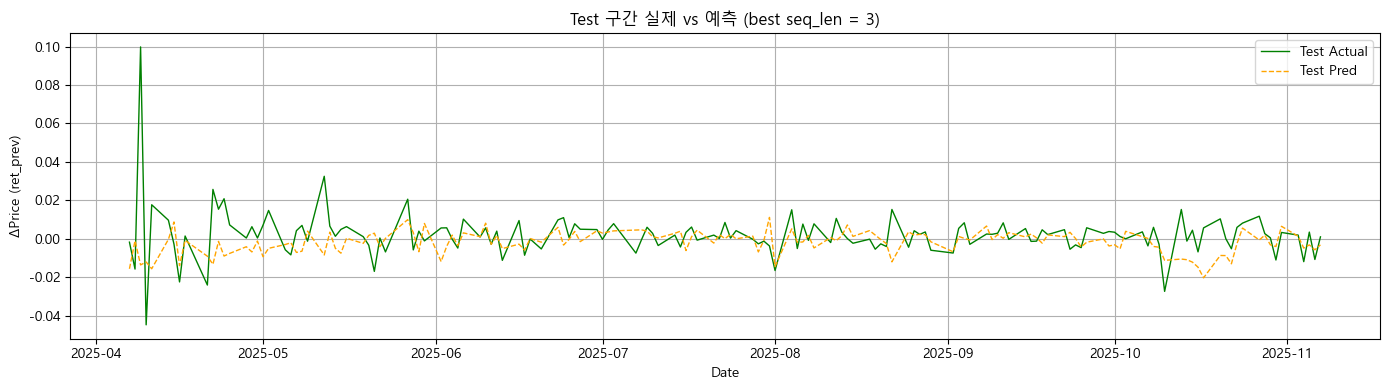

In [31]:
# ================== 4. 최적 seq_len 기준 Test 구간 시각화 ==================
import matplotlib.pyplot as plt  # 위에서 이미 import 했으면 생략

if 'date_all' not in globals():
    date_all = df.loc[X.index, "Date"].reset_index(drop=True)

if best_model_seq is not None and best_seq_len is not None:
    seq_len = best_seq_len

    # 1) 최적 seq_len으로 전체 시퀀스 다시 생성
    X_seq_all, y_seq_all = make_seq_dataset_for_reg(X, y, seq_len)
    n_samples = len(X_seq_all)

    # 시퀀스 마지막 시점에 대응하는 날짜 (타깃 y와 정렬)
    date_seq_all = date_all.iloc[seq_len-1 : seq_len-1 + n_samples].reset_index(drop=True)

    # 2) Train / Valid / Test 분할 (위에서 사용한 비율과 동일)
    test_ratio  = 0.2
    valid_ratio = 0.2

    test_size  = int(n_samples * test_ratio)
    remaining  = n_samples - test_size
    valid_size = int(remaining * valid_ratio)
    train_size = remaining - valid_size

    train_end = train_size
    valid_end = train_size + valid_size

    # Test 구간만 추출
    X_test_seq  = X_seq_all[valid_end:].reshape(test_size, -1)
    y_test_seq  = y_seq_all[valid_end:]
    date_test_seq = date_seq_all[valid_end:]

    # 3) 최적 모델로 Test 예측
    y_test_pred_best = best_model_seq.predict(X_test_seq)

    # 4) 시각화 (Test 구간만)
    plt.figure(figsize=(14, 4))
    plt.plot(date_test_seq, y_test_seq,       label="Test Actual",  color="green", linewidth=1)
    plt.plot(date_test_seq, y_test_pred_best, label="Test Pred",    color="orange", linestyle="--", linewidth=1)

    plt.title(f"Test 구간 실제 vs 예측 (best seq_len = {best_seq_len})")
    plt.xlabel("Date")
    plt.ylabel("ΔPrice (ret_prev)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("최적 seq_len 모델이 없어 Test 비교 그래프를 그릴 수 없습니다.")


최적 seq_len 차분 풀고 시각화


===== 로그 레벨 기준 (exp 없음) — 최종 Test 성능 =====
RMSE: 0.014115
MAE : 0.008295
R²  : 0.963353

CSV 저장 완료: ../../modeling/성능지표/SPY_XGBoost_지표.csv


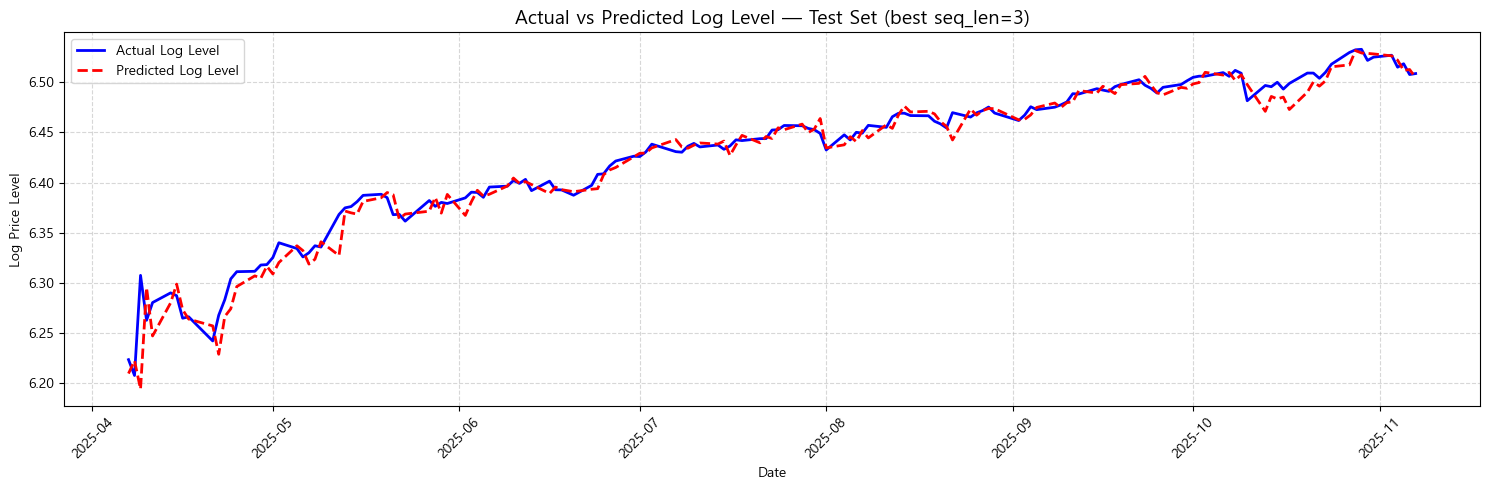

In [32]:
# ================== 4. 최적 seq_len 기준 Test 구간 (log 레벨 복원) ==================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 날짜 시리즈 (df_combined 기준)
date_all = df.loc[df_combined.index, "Date"].reset_index(drop=True)

if best_model_seq is not None and best_seq_len is not None:
    seq_len = best_seq_len

    # 1) 최적 seq_len 기준 전체 시퀀스 생성
    X_seq_all, y_seq_all = make_seq_dataset_for_reg(X, y, seq_len)
    n_samples = len(X_seq_all)

    # y_seq_all[k]는 원래 y의 (seq_len–1 + k) 번째 값
    orig_idx_all = np.arange(seq_len - 1, seq_len - 1 + n_samples)

    # 대응 날짜
    date_seq_all = date_all.iloc[orig_idx_all].reset_index(drop=True)

    # 2) Train / Valid / Test 분할 (동일 규칙 적용)
    test_ratio  = 0.2
    valid_ratio = 0.2

    test_size  = int(n_samples * test_ratio)
    remaining  = n_samples - test_size
    valid_size = int(remaining * valid_ratio)
    train_size = remaining - valid_size

    train_end = train_size
    valid_end = train_size + valid_size

    # 3D → 2D
    X_test_seq = X_seq_all[valid_end:].reshape(test_size, -1)
    y_test_seq = y_seq_all[valid_end:]                       # 실제 ret_prev
    date_test_seq = date_seq_all.iloc[valid_end:].reset_index(drop=True)

    # 3) 최적 모델로 예측 (ret_prev)
    y_test_pred_best = best_model_seq.predict(X_test_seq)

    # ==================================================================
    # ret_prev → log 레벨 복원(exp 없이)
    # ==================================================================

    # df_combined에 맞춘 로그 레벨
    y_log_all = df.loc[df_combined.index, "y_target_log"].reset_index(drop=True)

    # Test 시작 지점 (시퀀스 기준)
    test_start_idx = orig_idx_all[valid_end]
    n_test = len(y_test_seq)

    # 실제 로그 레벨
    log_true = y_log_all.iloc[test_start_idx : test_start_idx + n_test].reset_index(drop=True)

    # 바로 직전 로그 레벨
    log_prev = y_log_all.iloc[test_start_idx - 1 : test_start_idx - 1 + n_test].reset_index(drop=True)

    # 예측된 log 레벨 = log_prev + pred(ret_prev)
    log_pred = log_prev + y_test_pred_best

    # 비교용 DF
    comparison_log_df = pd.DataFrame(
        {
            "Actual_Log_Level": log_true.to_numpy(),
            "Pred_Log_Level": log_pred.to_numpy(),
        },
        index=date_test_seq
    )
    comparison_log_df.index.name = "Date"

    # 성능
    rmse_log = np.sqrt(mean_squared_error(comparison_log_df["Actual_Log_Level"],
                                          comparison_log_df["Pred_Log_Level"]))
    mae_log  = mean_absolute_error(comparison_log_df["Actual_Log_Level"],
                                   comparison_log_df["Pred_Log_Level"])
    r2_log   = r2_score(comparison_log_df["Actual_Log_Level"],
                        comparison_log_df["Pred_Log_Level"])

    print("\n===== 로그 레벨 기준 (exp 없음) — 최종 Test 성능 =====")
    print(f"RMSE: {rmse_log:.6f}")
    print(f"MAE : {mae_log:.6f}")
    print(f"R²  : {r2_log:.6f}")
    print("====================================================")

    # ===========================================
    # CSV 저장
    # ===========================================

    metrics_df = pd.DataFrame({
        "SPY_XGBoost_RMSE": [rmse_log],
        "SPY_XGBoost_R2": [r2_log]
    })

    save_path = "../../modeling/성능지표/SPY_XGBoost_지표.csv"
    metrics_df.to_csv(save_path, index=False, encoding="utf-8-sig")

    print(f"\nCSV 저장 완료: {save_path}")

    # ==================================================================
    # 시각화 (로그 레벨 기준)
    # ==================================================================
    plt.figure(figsize=(15, 5))

    plt.plot(comparison_log_df.index,
             comparison_log_df["Actual_Log_Level"],
             label="Actual Log Level", linewidth=2, color="blue")

    plt.plot(comparison_log_df.index,
             comparison_log_df["Pred_Log_Level"],
             label="Predicted Log Level", linewidth=2,
             linestyle="--", color="red")

    plt.title(f"Actual vs Predicted Log Level — Test Set (best seq_len={best_seq_len})", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Log Price Level")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("최적 seq_len 모델이 없어 Test log level 비교 그래프를 그릴 수 없습니다.")


In [33]:
import joblib
import os

# ============================================================
# 0. LightGBM (혹은 다중회귀) 최적 모델 저장
#    (이 코드는 Test 구간 예측/평가 코드 블록 앞에 위치해야 함)
# ============================================================

# (가정: best_seq_len 및 best_model_seq 변수가 이전에 정의되었다고 가정)

if 'best_model_seq' in locals() and best_model_seq is not None:
    # 모델 파일 이름 결정 (예시: best_lgbm_model_seq_X.joblib 또는 best_reg_model_seq_X.joblib)
    # 모델의 종류를 파일명에 명시하는 것이 좋습니다. 여기서는 'lgbm' 또는 'reg' 중 하나를 선택해야 합니다.
    # LightGBM을 사용했다면:
    model_type = "XGboost" 
    # 다중회귀(LinearRegression)를 사용했다면:
    # model_type = "reg"
    
    model_dir = "../../modeling/Model/"
    model_filename = f"{model_type}_best.joblib"
    model_path = os.path.join(model_dir, model_filename)

    # 모델 디렉토리가 없다면 생성
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # 모델 저장
    try:
        joblib.dump(best_model_seq, model_path)
        
        print(f"\n 최종 모델 (seq_len={best_seq_len})이 성공적으로 저장되었습니다.")
        print(f"   경로: {model_path}")

    except Exception as e:
        print(f"\n 모델 저장 중 오류 발생: {e}")

else:
    print("\n모델 저장 불가: 'best_model_seq' 변수에 저장된 최적 모델 객체가 유효하지 않습니다.")


 최종 모델 (seq_len=3)이 성공적으로 저장되었습니다.
   경로: ../../modeling/Model/XGboost_best.joblib
